In [48]:
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import FunctionTransformer, LabelEncoder


import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
#Loading the data
train_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
movies_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')


# EDA

In [50]:
# Join the two datasets on the 'movieid' column
merged_data = pd.merge(train_data, movies_data, on='movieid', how='inner').drop_duplicates()

# Display summary statistics of the merged dataframe
merged_data.describe(include='all')

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
count,307979,307979,307979,295024,307979,307979,216573.000000,129370,129370,175695,241608,293557.000000,298870,295807,307979,139534,163392,105555
unique,16812,4482,2,155071,2,16812,NaN,7,5371,5066,3249,NaN,1339,96,13038,3918,1913,487
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Finally the film loses its tension.,POSITIVE,Escape The Terminator Tyler Durden Astonish,NaN,R,['Language'],2017-07-14,2017-05-22,NaN,Drama,English,Joseph Brooks,$1.1M,Warner Bros. Pictures,Dolby Digital
freq,51538,1921,214212,74,204534,51538,NaN,65151,2995,884,2206,NaN,57641,228504,2794,963,9489,16464
mean,NaN,NaN,NaN,NaN,NaN,NaN,63.231636,NaN,NaN,NaN,NaN,102.419281,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,20.977627,NaN,NaN,NaN,NaN,25.884408,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,48.000000,NaN,NaN,NaN,NaN,90.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,66.000000,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN,115.000000,NaN,NaN,NaN,NaN,NaN,NaN


* There are 2 numerical features in the dataset of 'audienceScore' and 'runtimeMinutes'
* Lot of NaN values because they are categorical features


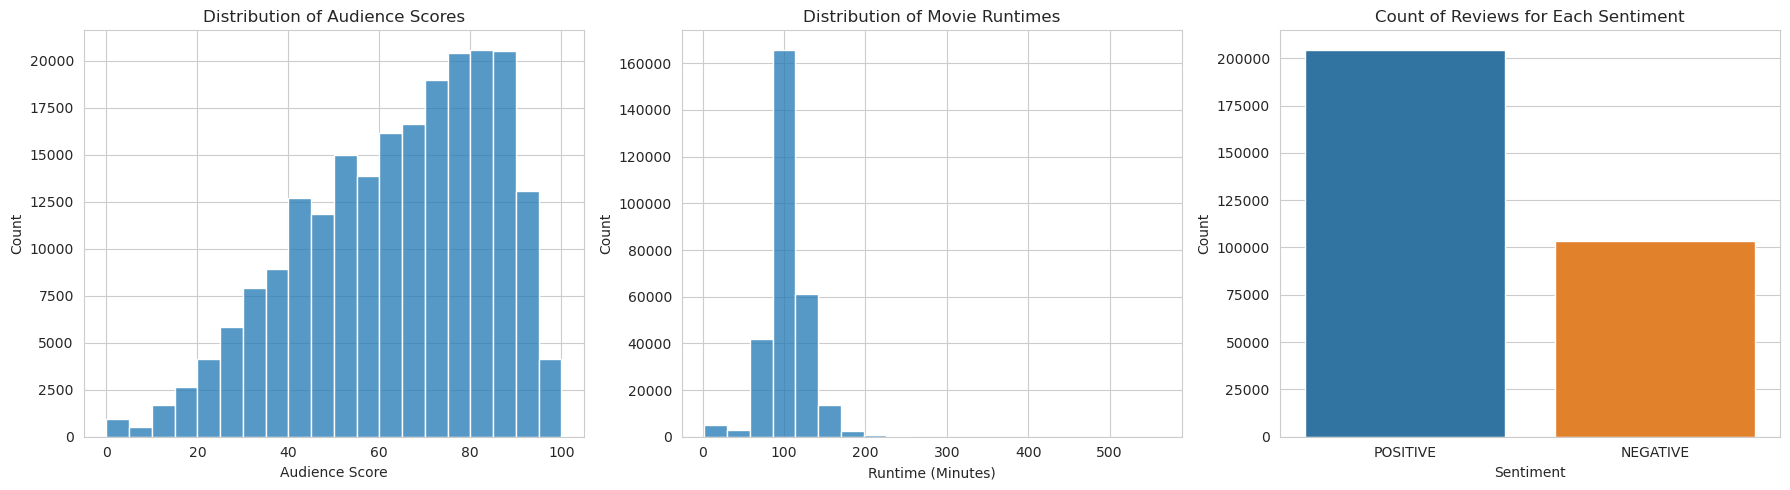

In [51]:
# Set the style for seaborn plots
sns.set_style('whitegrid')

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the distribution of audience scores
sns.histplot(merged_data['audienceScore'], bins=20, ax=axes[0])
axes[0].set_title('Distribution of Audience Scores')
axes[0].set_xlabel('Audience Score')
axes[0].set_ylabel('Count')

# Plot the distribution of movie runtimes
sns.histplot(merged_data['runtimeMinutes'], bins=20, ax=axes[1])
axes[1].set_title('Distribution of Movie Runtimes')
axes[1].set_xlabel('Runtime (Minutes)')
axes[1].set_ylabel('Count')

# Plot the count of reviews for each sentiment
sns.countplot(data=merged_data, x='sentiment', ax=axes[2])
axes[2].set_title('Count of Reviews for Each Sentiment')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Count')

# Show the plots
plt.tight_layout()
plt.show()

**1. Distribution of Audience Scores:** The histogram of audience scores shows that the scores are distributed across the entire range from 0 to 100. However, there are some peaks around scores of 40, 60, and 80.

**2. Distribution of Movie Runtimes:** The histogram of movie runtimes shows that most movies have a runtime of around 90 to 120 minutes, which is typical for feature films. There are some outliers with longer or shorter runtimes.

**3. Count of Reviews for Each Sentiment:** The bar plot of review sentiment shows that the dataset contains more positive reviews than negative reviews.

In [52]:
# Keeping only the 'reviewText' and 'sentiment' columns for the analysis
train_data = train_data[['reviewText', 'sentiment']]

train_data.head()

,reviewText,sentiment
0,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,Creed II does not give us anything but another...,POSITIVE
3,"I know what you're thinking, but this is no Li...",POSITIVE
4,Director Fernando Meirelles tells the story wi...,POSITIVE


In [53]:
#Droping the duplicates
train_data = train_data.drop_duplicates()
train_data.shape

(155082, 2)

In [54]:
# Function to clean the text
def preprocess_reviewtext(text):
        # Remove numbers
        text = re.sub(r'\d+', '', text)      
        return text

In [55]:
# Wrap functions using FunctionTransformer
fillna_transformer = FunctionTransformer(lambda x: x.fillna(''), validate=False)
preprocess_transformer = FunctionTransformer(lambda x: x.apply(preprocess_reviewtext), validate=False)

In [56]:
# Seprating the variables
X= train_data['reviewText']
y= train_data['sentiment']

In [57]:
# Splitting the data into features (reviewText) and target (sentiment)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model

In [58]:
"""#Pipeline for Logistic Regression
pipeline_lr = Pipeline([
    ('fillna', fillna_transformer),
    ('preprocess', preprocess_transformer),
    ('tfidf', TfidfVectorizer()),
    ('logistic_regression_model', LogisticRegression())
])
# Define the parameter grid
param_grid_lr = {
    'logistic_regression_model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logistic_regression_model__max_iter': [100, 200, 500]
}

# Create a GridSearchCV object
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, scoring='accuracy', cv=5)

# Fit the GridSearchCV object on the training data
grid_search_lr.fit(X_train, y_train)

# Access the best hyperparameters and best estimator
best_params_lr = grid_search_lr.best_params_
best_estimator_lr = grid_search_lr.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", best_params_lr)

# Predict using the best estimator on training data
y_train_lr_pred_best = best_estimator_lr.predict(X_train)

# Predict using the best estimator on validation data
y_val_lr_pred_best = best_estimator_lr.predict(X_val)

# Compute accuracy for training data
train_accuracy_lr_best = accuracy_score(y_train, y_train_lr_pred_best)

# Compute accuracy for validation data
val_accuracy_lr_best = accuracy_score(y_val, y_val_lr_pred_best)

print("Best Model Training Accuracy:", train_accuracy_lr_best)
print("Best Model Validation Accuracy:", val_accuracy_lr_best)

#OutPut
Best hyperparameters: {'logistic_regression_model__C': 1, 'logistic_regression_model__max_iter': 100}
Best Model Training Accuracy: 0.8490065691371459
Best Model Validation Accuracy: 0.8024309249766257"""

'#Pipeline for Logistic Regression\npipeline_lr = Pipeline([\n    (\'fillna\', fillna_transformer),\n    (\'preprocess\', preprocess_transformer),\n    (\'tfidf\', TfidfVectorizer()),\n    (\'logistic_regression_model\', LogisticRegression())\n])\n# Define the parameter grid\nparam_grid_lr = {\n    \'logistic_regression_model__C\': [0.001, 0.01, 0.1, 1, 10, 100],\n    \'logistic_regression_model__max_iter\': [100, 200, 500]\n}\n\n# Create a GridSearchCV object\ngrid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, scoring=\'accuracy\', cv=5)\n\n# Fit the GridSearchCV object on the training data\ngrid_search_lr.fit(X_train, y_train)\n\n# Access the best hyperparameters and best estimator\nbest_params_lr = grid_search_lr.best_params_\nbest_estimator_lr = grid_search_lr.best_estimator_\n\n# Print the best hyperparameters\nprint("Best hyperparameters:", best_params_lr)\n\n# Predict using the best estimator on training data\ny_train_lr_pred_best = best_estimator_lr.predict(X_train)\n\n#

In [59]:
#Pipeline for Logistic Regression
pipeline_lr = Pipeline([
    ('fillna', fillna_transformer),
    ('preprocess', preprocess_transformer),
    ('tfidf', TfidfVectorizer()),
    ('logistic_regression_model', LogisticRegression(C=1, max_iter = 100))
])

# Fit the GridSearchCV object on the training data
pipeline_lr.fit(X_train, y_train)

# Predict using the best estimator on validation data
y_val_lr_pred = pipeline_lr.predict(X_val)

# Compute accuracy for validation data
val_accuracy_lr = accuracy_score(y_val, y_val_lr_pred)

In [60]:
#Creating Classification Report for LR
print("Classification Report for Logistic Regression:","\n",classification_report(y_val, y_val_lr_pred))

Classification Report for Logistic Regression: 
               precision    recall  f1-score   support

    NEGATIVE       0.76      0.60      0.67     10246
    POSITIVE       0.82      0.91      0.86     20771

    accuracy                           0.81     31017
   macro avg       0.79      0.75      0.77     31017
weighted avg       0.80      0.81      0.80     31017



# Decision Tree Model

In [61]:
"""#Pipeline for DecisionTree
pipeline_DT = Pipeline([
    ('fillna', fillna_transformer),
    ('preprocess', preprocess_transformer),
    ('tfidf', TfidfVectorizer()),
    ('decision_tree_model', DecisionTreeClassifier())
])
# Define the parameter grid
param_grid_DT = {
    'decision_tree_model__criterion': ['gini', 'entropy'],
    'decision_tree_model__max_depth': [5, 10, 15, 20],
    'decision_tree_model__min_samples_leaf': [1, 3, 5, 7]
}

# Create a GridSearchCV object
grid_search_DT = GridSearchCV(pipeline_DT, param_grid_DT, scoring='accuracy', cv=5)

# Fit the GridSearchCV object on the training data
grid_search_DT.fit(X_train, y_train)

# Access the best hyperparameters and best estimator
best_params_DT = grid_search_DT.best_params_
best_estimator_DT = grid_search_DT.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", best_params_DT)

# Predict using the best estimator on training data
y_train_DT_pred_best = best_estimator_DT.predict(X_train)

# Predict using the best estimator on validation data
y_val_DT_pred_best = best_estimator_DT.predict(X_val)

# Compute accuracy for training data
train_accuracy_DT_best = accuracy_score(y_train, y_train_DT_pred_best)

# Compute accuracy for validation data
val_accuracy_DT_best = accuracy_score(y_val, y_val_DT_pred_best)

print("Best Model Training Accuracy:", train_accuracy_DT_best)
print("Best Model Validation Accuracy:", val_accuracy_DT_best)

#OutPut
Best hyperparameters: {'decision_tree_model__criterion': 'gini', 'decision_tree_model__max_depth': 20, 'decision_tree_model__min_samples_leaf': 7}
Best Model Training Accuracy: 0.7052512795711925
Best Model Validation Accuracy: 0.6987780894348261"""

'#Pipeline for DecisionTree\npipeline_DT = Pipeline([\n    (\'fillna\', fillna_transformer),\n    (\'preprocess\', preprocess_transformer),\n    (\'tfidf\', TfidfVectorizer()),\n    (\'decision_tree_model\', DecisionTreeClassifier())\n])\n# Define the parameter grid\nparam_grid_DT = {\n    \'decision_tree_model__criterion\': [\'gini\', \'entropy\'],\n    \'decision_tree_model__max_depth\': [5, 10, 15, 20],\n    \'decision_tree_model__min_samples_leaf\': [1, 3, 5, 7]\n}\n\n# Create a GridSearchCV object\ngrid_search_DT = GridSearchCV(pipeline_DT, param_grid_DT, scoring=\'accuracy\', cv=5)\n\n# Fit the GridSearchCV object on the training data\ngrid_search_DT.fit(X_train, y_train)\n\n# Access the best hyperparameters and best estimator\nbest_params_DT = grid_search_DT.best_params_\nbest_estimator_DT = grid_search_DT.best_estimator_\n\n# Print the best hyperparameters\nprint("Best hyperparameters:", best_params_DT)\n\n# Predict using the best estimator on training data\ny_train_DT_pred_bes

In [62]:
#Pipeline for DecisionTree
pipeline_DT = Pipeline([
    ('fillna', fillna_transformer),
    ('preprocess', preprocess_transformer),
    ('tfidf', TfidfVectorizer()),
    ('decision_tree_model', DecisionTreeClassifier(criterion = "gini", max_depth = 20, min_samples_leaf = 7))
])

# Fit the GridSearchCV object on the training data
pipeline_DT.fit(X_train, y_train)

# Predict using the best estimator on validation data
y_val_DT_pred = pipeline_DT.predict(X_val)

# Compute accuracy for validation data
val_accuracy_DT = accuracy_score(y_val, y_val_DT_pred)

In [63]:
#Creating Classification Report for DT
print("Classification Report for Decision Tree:","\n",classification_report(y_val, y_val_DT_pred))

Classification Report for Decision Tree: 
               precision    recall  f1-score   support

    NEGATIVE       0.62      0.19      0.29     10246
    POSITIVE       0.70      0.94      0.81     20771

    accuracy                           0.69     31017
   macro avg       0.66      0.57      0.55     31017
weighted avg       0.68      0.69      0.63     31017



# Multinomial Naive Bayes Model


In [64]:
"""
# Create the enhanced end-to-end pipeline
pipeline_MNB = Pipeline([
    ('fillna', fillna_transformer),
    ('preprocess', preprocess_transformer),
    ('tfidf', TfidfVectorizer()), 
    ('multinomialNB_model', MultinomialNB())
])

# Hyperparameters to tune
params = {
    'multinomialNB_model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0]
}

# Grid search with cross-validation
grid_search_mnb = GridSearchCV(pipeline_MNB, params, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_mnb.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding score
best_params_mnb = grid_search_mnb.best_params_
best_score_mnb = grid_search_mnb.best_score_
best_pipeline = grid_search_mnb.best_estimator_

best_params_mnb, best_score_mnb

# Predict using the pipeline on training data
y_train_pred_MNB = best_pipeline.predict(X_train)

# Predict using the pipeline on validation data
y_val_pred_MNB = pipeline_MNB.predict(X_val)

# Compute accuracy for training data
train_accuracy_MNB = accuracy_score(y_train, y_train_pred_MNB)

# Compute accuracy for validation data
val_accuracy_MNB = accuracy_score(y_val, y_val_pred_MNB)

print("MultinomialNB Training Accuracy:", train_accuracy_MNB)
print("MultinomialNB Validation Accuracy:", val_accuracy_MNB)

#OutPut
({'multinomialNB_model__alpha': 0.001}, 0.7694595574900254)
MultinomialNB Training Accuracy: 0.780002418087293
MultinomialNB Validation Accuracy: 0.7718025598865138
"""

'\n# Create the enhanced end-to-end pipeline\npipeline_MNB = Pipeline([\n    (\'fillna\', fillna_transformer),\n    (\'preprocess\', preprocess_transformer),\n    (\'tfidf\', TfidfVectorizer()), \n    (\'multinomialNB_model\', MultinomialNB())\n])\n\n# Hyperparameters to tune\nparams = {\n    \'multinomialNB_model__alpha\': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0]\n}\n\n# Grid search with cross-validation\ngrid_search_mnb = GridSearchCV(pipeline_MNB, params, cv=5, scoring=\'accuracy\')\n\n# Fit the grid search to the data\ngrid_search_mnb.fit(X_train, y_train)\n\n# Get the best hyperparameters and the corresponding score\nbest_params_mnb = grid_search_mnb.best_params_\nbest_score_mnb = grid_search_mnb.best_score_\nbest_pipeline = grid_search_mnb.best_estimator_\n\nbest_params_mnb, best_score_mnb\n\n# Predict using the pipeline on training data\ny_train_pred_MNB = best_pipeline.predict(X_train)\n\n# Predict using the pipeline on validation data\ny_val_pred_MNB = pipeline_MNB.predict(X_val)\n\

In [65]:
# Create the enhanced end-to-end pipeline
pipeline_MNB = Pipeline([
    ('fillna', fillna_transformer),
    ('preprocess', preprocess_transformer),
    ('tfidf', TfidfVectorizer()), 
    ('multinomialNB_model', MultinomialNB(alpha = 0.001))
])

# Fit the grid search to the data
pipeline_MNB.fit(X_train, y_train)

# Predict using the pipeline on validation data
y_val_MNB_pred = pipeline_MNB.predict(X_val)

# Compute accuracy for validation data
val_accuracy_MNB = accuracy_score(y_val, y_val_MNB_pred)

In [66]:
#Creating Classification Report for MNB
print("Classification Report for MultinomialNB:","\n",classification_report(y_val, y_val_MNB_pred))

Classification Report for MultinomialNB: 
               precision    recall  f1-score   support

    NEGATIVE       0.73      0.47      0.57     10246
    POSITIVE       0.78      0.91      0.84     20771

    accuracy                           0.77     31017
   macro avg       0.76      0.69      0.71     31017
weighted avg       0.76      0.77      0.75     31017



# Comparing Models

In [67]:
# Display the validation accuracy for each model
val_accuracies = {
    "Logistic Regression": val_accuracy_lr,
    "Decision Tree": val_accuracy_DT,
    "Multinomial Naive Bayes": val_accuracy_MNB
}

print("Validation Accuracies:", val_accuracies)

Validation Accuracies: {'Logistic Regression': 0.8056227230228584, 'Decision Tree': 0.6938775510204082, 'Multinomial Naive Bayes': 0.7683850791501434}


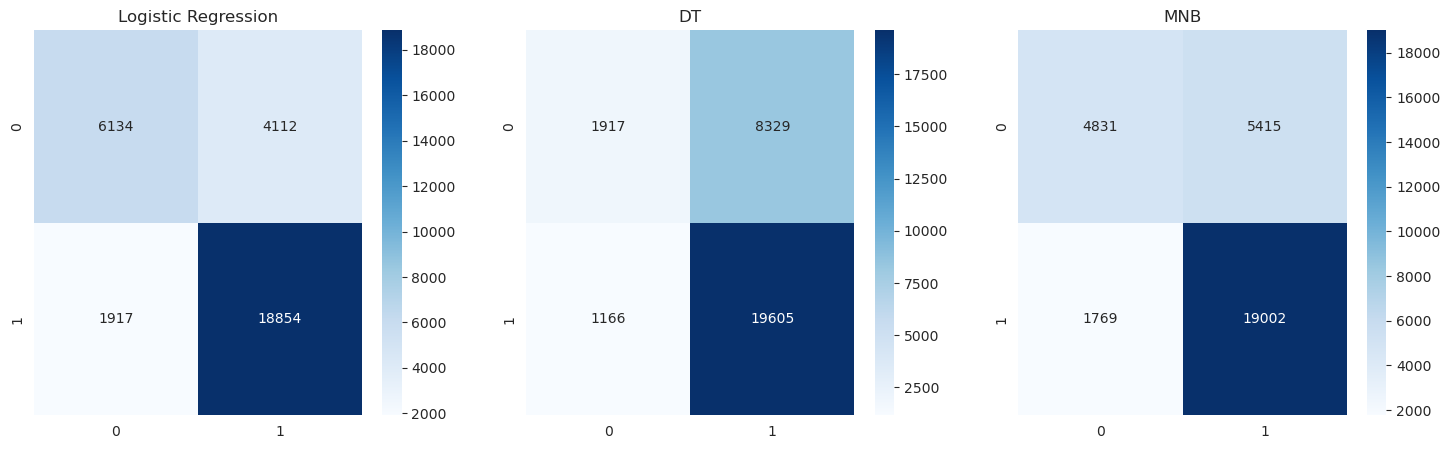

In [68]:
cm_lr = confusion_matrix(y_val, y_val_lr_pred)
cm_DT = confusion_matrix(y_val, y_val_DT_pred)
cm_MNB = confusion_matrix(y_val, y_val_MNB_pred)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues')
plt.title('Logistic Regression')

plt.subplot(1, 3, 2)
sns.heatmap(cm_DT, annot=True, fmt='g', cmap='Blues')
plt.title('DT')

plt.subplot(1, 3, 3)
sns.heatmap(cm_MNB, annot=True, fmt='g', cmap='Blues')
plt.title('MNB')

plt.show()

# [[TN, FP]
# [FN, TP]]
* The Logistic Regression model has a more balanced performance, with a good number of both True Positives and True Negatives. 
* The Decision Tree model excels at predicting Positives but struggles with Negatives. 
* The MultinomialNB model has a good overall performance but may have a slightly higher misclassification rate for both classes compared to Logistic Regression.

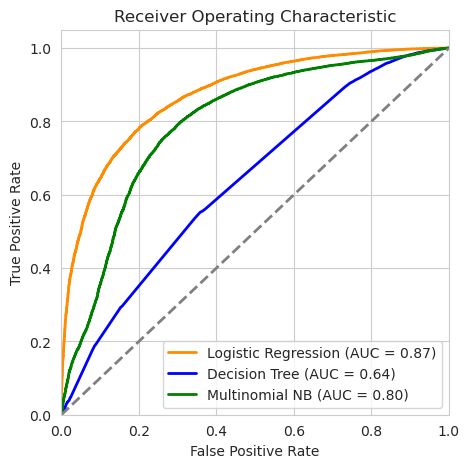

In [69]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format using LabelEncoder
label_encoder = LabelEncoder()
y_val_binary = label_encoder.fit_transform(y_val)

# Get predicted probabilities for the positive class
y_val_lr_pred_proba = pipeline_lr.predict_proba(X_val)[:, 1]

# Calculate TPR and FPR for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_val_binary, y_val_lr_pred_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Get predicted probabilities for the positive class
y_val_DT_pred_proba = pipeline_DT.predict_proba(X_val)[:, 1]

# Calculate TPR and FPR for Decision Tree
fpr_DT, tpr_DT, _ = roc_curve(y_val_binary, y_val_DT_pred_proba)
roc_auc_DT = auc(fpr_DT, tpr_DT)

# Get predicted probabilities for the positive class
y_val_MNB_pred_proba = pipeline_MNB.predict_proba(X_val)[:, 1]

# Calculate TPR and FPR for Multinomial Naive Bayes
fpr_MNB, tpr_MNB, _ = roc_curve(y_val_binary, y_val_MNB_pred_proba)
roc_auc_MNB = auc(fpr_MNB, tpr_MNB)

# Plot ROC curves
plt.figure(figsize=(5, 5))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_DT, tpr_DT, color='blue', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_DT)
plt.plot(fpr_MNB, tpr_MNB, color='green', lw=2, label='Multinomial NB (AUC = %0.2f)' % roc_auc_MNB)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Logisctic Regression has the highest score 
#### So let's fit it

In [70]:
#Loading test data
test_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [71]:
# Transforming the test data and making predictions
test_predictions= pipeline_lr.predict(test_data['reviewText'])

test_predictions.shape

(55315,)

In [72]:
# Creating a submission DataFrame with the predicted sentiments
submission = pd.DataFrame(columns=['id', 'sentiment'])

submission['id']= [i for i in range(len(test_predictions))]
submission['sentiment'] =test_predictions

In [73]:
submission.shape

(55315, 2)

In [74]:
submission.info

<bound method DataFrame.info of           id sentiment
0          0  POSITIVE
1          1  POSITIVE
2          2  POSITIVE
3          3  POSITIVE
4          4  POSITIVE
...      ...       ...
55310  55310  POSITIVE
55311  55311  NEGATIVE
55312  55312  POSITIVE
55313  55313  POSITIVE
55314  55314  NEGATIVE

[55315 rows x 2 columns]>

In [75]:
#Creating the file
submission.to_csv('submission.csv', index=False)

In [76]:
confirm = pd.read_csv('submission.csv')
confirm.head()

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
